#### SUMMARY: Final model

**using this there is no need to reload your packages every time when you will make any improvement to them**

In [1]:
%load_ext autoreload

In [2]:
autoreload 2

**import necessary libraries**

In [3]:
import numpy as np
import pandas as pd 
import sys
import warnings

**set warnings options**

In [4]:
warnings.filterwarnings('ignore')

#### to have ease in importing modules

In [5]:
sys.path.insert(0, '/Users/mjasiecz/PycharmProjects/new_offer_success_predictor/src')

**set pandas options**

In [6]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200

**import packages for manage and preprocess data**

In [7]:
from data.data_manager import DataManager
from data.data_processor import DataProcessor, TestDataProcessor
from ml_preprocessing.categorical_encoders import LeaveOneOutEncoder
from ml_preprocessing.encoding_helpers import LOOGridSearchCV

Using TensorFlow backend.


**import scores function**

In [8]:
from utils.scores_function import scores_function

**load data pipeline**

In [9]:
DM = DataManager()
train_df, test_df = DM.load_train_test()

**ml data preprocessing**

In [10]:
DP = DataProcessor(train_df=train_df)
processed_train_df = DP.perform_initial_features_engineering()
TDP = TestDataProcessor(not_processed_train_df=train_df,
                        processed_train_df=processed_train_df,
                        test_df=test_df,
                        sneaky_peaky=True)
processed_test_df = TDP.perform_initial_features_engineering()

Imputing row 1/1031 with 1 missing, elapsed time: 0.208
Imputing row 1/1289 with 0 missing, elapsed time: 0.392
Imputing row 1033/1289 with 0 missing, elapsed time: 0.396


**sklearn modelling**

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, make_scorer

In [12]:
columns_to_encode = ['offer_class', 'gender', 'customer_type', 'center', 'phone_calls', 'cc_len', 'cc_startswith']

In [13]:
enc = LeaveOneOutEncoder(train_df=processed_train_df,
                         test_df=processed_test_df,
                         columns_to_encode=columns_to_encode,
                         target_column='target',
                         random_state=42,
                         mean=1,
                         std=0.05)

In [14]:
_, test_df_encoded = enc.fit()

In [15]:
X_test = test_df_encoded.reset_index().drop(columns=['target'])
y_test = test_df_encoded.reset_index()[['target']]

In [16]:
y_train = processed_train_df[['target']].reset_index().drop(columns=['name'])

In [17]:
all_train_features = processed_train_df.columns.values

#### estimators

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf_clf = RandomForestClassifier()

In [20]:
rf_param_grid = {'n_estimators': [4, 8, 10, 20, 30, 50, 70, 90, 100, 200],
                 'max_depth': list(np.linspace(2, 10 , 5, endpoint=True).astype(int)),
                 'max_features': list(np.linspace(2, 8, 4, endpoint=True).astype(int)),
                 'random_state': [42]}

**final set of chosen features**

In [21]:
columns_to_drop_from_training1 = ['salary', 'scaled_salary','scaled_age_knn', 'scaled_estimated_expenses_knn',
                                  'scaled_offer_value_knn', 'estimated_expenses_knn', 'offer_value_knn',
                                  'age_knn', 'log_age_knn', 'age']

In [22]:
set(all_train_features).difference(set(columns_to_drop_from_training1))

{'cc_len',
 'cc_startswith',
 'center',
 'customer_type',
 'emails',
 'gender',
 'log_estimated_expenses_knn',
 'log_offer_value_knn',
 'log_salary',
 'nan_age',
 'not_nan_age',
 'offer_class',
 'phone_calls',
 'target'}

In [23]:
test_df_encoded_ohemails = test_df_encoded.copy(deep=True)
email_ohe_names = {0: '0_emails',
                   1: '1_email',
                   2: '2_emails',
                   3: '3_emails',
                   4: '4_emails',
                   5: '5_emails'}

test_df_encoded_ohemails = (pd.concat([test_df_encoded_ohemails, pd.get_dummies(test_df_encoded_ohemails['emails'])],
                                      axis=1).rename(columns=email_ohe_names)).drop(columns=['emails'])

In [24]:
LOOGS1_rf = LOOGridSearchCV(train_df=processed_train_df, model=rf_clf, params_grid=rf_param_grid, 
                        columns_to_encode=columns_to_encode,
                        columns_to_drop_from_training=columns_to_drop_from_training1)

In [25]:
rf1_roc_auc = LOOGS1_rf.grid_search()

In [26]:
test1 = test_df_encoded_ohemails[LOOGS1_rf.processed_train().columns.values]

In [27]:
train1 = LOOGS1_rf.processed_train()

In [28]:
print(max(rf1_roc_auc))

0.7728714678462344


In [29]:
scores_function(model=LOOGS1_rf, X_train=train1 , X_test=test1, y_train=y_train , y_test=y_test, mode='loo')

generalization error: 0.005235259864815434
roc_auc_score: 0.7602678571428573
recall_score: 0.7142857142857143
accuracy_score: 0.7713178294573644
precision_score: 0.693069306930693
confusion_matrix: 

[[129  31]
 [ 28  70]]


In [30]:
import pickle

from pathlib import Path

In [31]:
models_path = Path('/Users/mjasiecz/PycharmProjects/new_offer_success_predictor/models/final_model.pickle')

In [32]:
if not models_path.exists():
    print('be sure to change model path my friend :)') #drop if you are project author and make next cell to 'Code' mode

In [33]:
final_model = pickle.load(open(models_path, 'rb'))

In [34]:
final_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
scores_function(model=final_model, X_train=train1 , X_test=test1, y_train=y_train , y_test=y_test, mode='pickle')

generalization error: 0.005235259864815434
roc_auc_score: 0.7602678571428573
recall_score: 0.7142857142857143
accuracy_score: 0.7713178294573644
precision_score: 0.693069306930693
confusion_matrix: 

[[129  31]
 [ 28  70]]


In [36]:
customer_names = test1.reset_index()[['name']]

In [37]:
probabilities = pd.DataFrame({'probability': final_model.predict_proba(test1)[:, 1]})

In [38]:
final_list_of_probabilities = pd.merge(customer_names, probabilities, how='inner', on=customer_names.index)

In [39]:
final_list_of_probabilities = final_list_of_probabilities[['name', 'probability']]

In [40]:
final_list_of_probabilities.head()

,name,probability
0,DA3BAEB8BF604EB,0.213702
1,AEF3DE08DFED4E0,0.156127
2,B621BB29484E46D,0.156127
3,2D0945802F92423,0.567772
4,640ABFC7E49B403,0.362936


#### Factors impacting classification results

In [41]:
import shap
import matplotlib.pyplot as plt

In [42]:
explainer = shap.TreeExplainer(final_model)

In [43]:
shap_values = explainer.shap_values(test1)

In [44]:
test1.head()# <- look at during presentation preparation <- it should contain many valuable information on how to interpet shap value

,log_salary,log_estimated_expenses_knn,log_offer_value_knn,nan_age,not_nan_age,0_emails,1_email,2_emails,3_emails,4_emails,5_emails,encoded_offer_class,encoded_gender,encoded_customer_type,encoded_center,encoded_phone_calls,encoded_cc_len,encoded_cc_startswith
name,,,,,,,,,,,,,,,,,,
DA3BAEB8BF604EB,6.594755,8.940891,4.963600,True,False,0,1,0,0,0,0,0.256637,0.191617,0.318820,0.365801,0.341429,0.316583,0.366552
AEF3DE08DFED4E0,6.656084,8.662851,4.153202,False,True,1,0,0,0,0,0,0.256637,0.191617,0.318820,0.365801,0.341429,0.316583,0.366552
B621BB29484E46D,6.671501,8.434898,5.348081,False,True,0,1,0,0,0,0,0.256637,0.191617,0.318820,0.390158,0.341429,0.316583,0.366552
2D0945802F92423,6.514713,8.402680,4.876044,False,True,0,1,0,0,0,0,0.256637,0.724518,0.371134,0.390158,0.341429,0.316583,0.366552
640ABFC7E49B403,8.029296,8.388450,5.193064,False,True,0,1,0,0,0,0,0.618474,0.191617,0.576577,0.390158,0.341429,0.591489,0.366552


In [45]:
%matplotlib inline

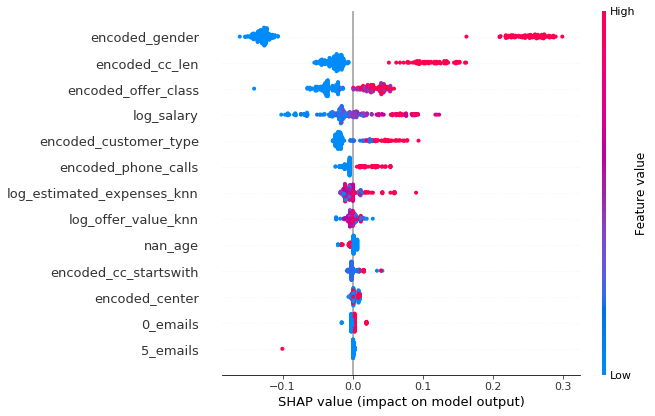

In [46]:
shap.summary_plot(shap_values[1], test1, max_display=13)

in classification problems, there are separate array of SHAP values for each possible outcome. In this case, we use 1 as an index to get the SHAP values for the prediction of True (i.e. which features and how had the most impact on being assessed as a person, who will accept new offer)

#### use code below to generate shap summary plot to .png 

In [52]:
# %matplotlib auto

In [53]:
# fig = shap.summary_plot(shap_values[1], test1, show=False, max_display=13)

<br> (bad scalability)
<br> savefig doesnt work properly. you can do it manually, via pop-up window (after using magic matplotlib auto)
<br>(good scalability)
<br> print screen


In [49]:
# plt.savefig('/Users/mjasiecz/PycharmProjects/new_offer_success_predictor/presentations/business/plots/shap_feature_importance.png')

#### explaining shap values for encoded categorical variables - for presentation

In [50]:
test1['encoded_phone_calls'].value_counts()

0.341429    178
0.515748     59
0.500000     16
0.062500      4
0.315789      1
Name: encoded_phone_calls, dtype: int64

In [51]:
train_df[['phone_calls', 'accepted']].groupby(['phone_calls', 'accepted']).size()

phone_calls  accepted
0.0          no          461
             yes         239
1.0          no          122
             yes         130
2.0          no           13
             yes          13
3.0          no           13
             yes           6
4.0          no           16
             yes           2
5.0          no            5
8.0          no            9
dtype: int64

#### one extra model approach: using outcome of shap value plot

the idea here was to check if features with low impact on model outcome will not add any noise which could cause drop in recall (and they didn't hence 'raw' mode is set here and final model is still the same.